<a href="https://colab.research.google.com/github/nravinuthala/EVA4.0/blob/master/EVA4S6_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
1. Use L2 (weight decay of 0.01)
2. Run for 40 epochs
3. Save model

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())
'''
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
'''

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

NameError: ignored

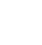

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 12

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
           nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.32706889510154724 Batch_id=468 Accuracy=61.56: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4491, Accuracy: 8860/10000 (88.60%)

EPOCH: 1


Loss=0.14437457919120789 Batch_id=468 Accuracy=93.27: 100%|██████████| 469/469 [00:12<00:00, 37.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2177, Accuracy: 9498/10000 (94.98%)

EPOCH: 2


Loss=0.18804697692394257 Batch_id=468 Accuracy=95.24: 100%|██████████| 469/469 [00:12<00:00, 36.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1606, Accuracy: 9630/10000 (96.30%)

EPOCH: 3


Loss=0.25378626585006714 Batch_id=468 Accuracy=95.80: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1363, Accuracy: 9677/10000 (96.77%)

EPOCH: 4


Loss=0.1772925853729248 Batch_id=468 Accuracy=96.01: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0875, Accuracy: 9801/10000 (98.01%)

EPOCH: 5


Loss=0.17520856857299805 Batch_id=468 Accuracy=95.93: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1323, Accuracy: 9678/10000 (96.78%)

EPOCH: 6


Loss=0.1776445508003235 Batch_id=468 Accuracy=96.01: 100%|██████████| 469/469 [00:12<00:00, 37.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1279, Accuracy: 9707/10000 (97.07%)

EPOCH: 7


Loss=0.29196539521217346 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1184, Accuracy: 9717/10000 (97.17%)

EPOCH: 8


Loss=0.1656925231218338 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:12<00:00, 38.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0951, Accuracy: 9782/10000 (97.82%)

EPOCH: 9


Loss=0.25460654497146606 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1148, Accuracy: 9722/10000 (97.22%)

EPOCH: 10


Loss=0.21530981361865997 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:12<00:00, 37.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1233, Accuracy: 9718/10000 (97.18%)

EPOCH: 11


Loss=0.24556653201580048 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:12<00:00, 36.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Accuracy: 9839/10000 (98.39%)

EPOCH: 12


Loss=0.25996941328048706 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:12<00:00, 37.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1239, Accuracy: 9658/10000 (96.58%)

EPOCH: 13


Loss=0.16600225865840912 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1284, Accuracy: 9713/10000 (97.13%)

EPOCH: 14


Loss=0.18669132888317108 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:12<00:00, 37.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0762, Accuracy: 9822/10000 (98.22%)

EPOCH: 15


Loss=0.20931845903396606 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1018, Accuracy: 9769/10000 (97.69%)

EPOCH: 16


Loss=0.1621796190738678 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:12<00:00, 37.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0804, Accuracy: 9804/10000 (98.04%)

EPOCH: 17


Loss=0.19998733699321747 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:12<00:00, 36.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0884, Accuracy: 9801/10000 (98.01%)

EPOCH: 18


Loss=0.17232264578342438 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:12<00:00, 36.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0868, Accuracy: 9789/10000 (97.89%)

EPOCH: 19


Loss=0.16694138944149017 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:12<00:00, 36.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1095, Accuracy: 9745/10000 (97.45%)

EPOCH: 20


Loss=0.180695042014122 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:12<00:00, 37.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0635, Accuracy: 9873/10000 (98.73%)

EPOCH: 21


Loss=0.20926368236541748 Batch_id=468 Accuracy=96.29: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1473, Accuracy: 9629/10000 (96.29%)

EPOCH: 22


Loss=0.14660432934761047 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1113, Accuracy: 9731/10000 (97.31%)

EPOCH: 23


Loss=0.14623261988162994 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:12<00:00, 36.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0805, Accuracy: 9835/10000 (98.35%)

EPOCH: 24


Loss=0.2496696263551712 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:12<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9795/10000 (97.95%)

EPOCH: 25


Loss=0.1780632734298706 Batch_id=468 Accuracy=96.32: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1747, Accuracy: 9562/10000 (95.62%)

EPOCH: 26


Loss=0.14407186210155487 Batch_id=468 Accuracy=96.29: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1739, Accuracy: 9526/10000 (95.26%)

EPOCH: 27


Loss=0.2074013203382492 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:12<00:00, 36.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1496, Accuracy: 9623/10000 (96.23%)

EPOCH: 28


Loss=0.16286130249500275 Batch_id=468 Accuracy=96.32: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0932, Accuracy: 9747/10000 (97.47%)

EPOCH: 29


Loss=0.2878086566925049 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Accuracy: 9838/10000 (98.38%)

EPOCH: 30


Loss=0.1412183791399002 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Accuracy: 9829/10000 (98.29%)

EPOCH: 31


Loss=0.13166671991348267 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:12<00:00, 36.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1326, Accuracy: 9658/10000 (96.58%)

EPOCH: 32


Loss=0.11000137776136398 Batch_id=468 Accuracy=96.10: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0947, Accuracy: 9756/10000 (97.56%)

EPOCH: 33


Loss=0.17589233815670013 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:12<00:00, 36.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1159, Accuracy: 9700/10000 (97.00%)

EPOCH: 34


Loss=0.34645989537239075 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9826/10000 (98.26%)

EPOCH: 35


Loss=0.23161619901657104 Batch_id=468 Accuracy=96.24: 100%|██████████| 469/469 [00:12<00:00, 36.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0872, Accuracy: 9799/10000 (97.99%)

EPOCH: 36


Loss=0.13670022785663605 Batch_id=468 Accuracy=96.27: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0735, Accuracy: 9813/10000 (98.13%)

EPOCH: 37


Loss=0.13692696392536163 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:12<00:00, 36.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0918, Accuracy: 9794/10000 (97.94%)

EPOCH: 38


Loss=0.1485874205827713 Batch_id=468 Accuracy=96.29: 100%|██████████| 469/469 [00:12<00:00, 36.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1255, Accuracy: 9687/10000 (96.87%)

EPOCH: 39


Loss=0.15731072425842285 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]



Test set: Average loss: 0.1591, Accuracy: 9573/10000 (95.73%)



In [0]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
convblock1.0.weight 	 torch.Size([8, 1, 3, 3])
convblock1.1.weight 	 torch.Size([8])
convblock1.1.bias 	 torch.Size([8])
convblock1.1.running_mean 	 torch.Size([8])
convblock1.1.running_var 	 torch.Size([8])
convblock1.1.num_batches_tracked 	 torch.Size([])
convblock2.0.weight 	 torch.Size([16, 8, 3, 3])
convblock2.1.weight 	 torch.Size([16])
convblock2.1.bias 	 torch.Size([16])
convblock2.1.running_mean 	 torch.Size([16])
convblock2.1.running_var 	 torch.Size([16])
convblock2.1.num_batches_tracked 	 torch.Size([])
convblock3.0.weight 	 torch.Size([8, 16, 1, 1])
convblock3.1.weight 	 torch.Size([8])
convblock3.1.bias 	 torch.Size([8])
convblock3.1.running_mean 	 torch.Size([8])
convblock3.1.running_var 	 torch.Size([8])
convblock3.1.num_batches_tracked 	 torch.Size([])
convblock4.0.weight 	 torch.Size([16, 8, 3, 3])
convblock4.1.weight 	 torch.Size([16])
convblock4.1.bias 	 torch.Size([16])
convblock4.1.running_mean 	 torch.Size([16])
convblock4.1.running_var 	 torc

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!mkdir models
#!pwd
#!ls
!ls -l ./models

total 48
-rw-r--r-- 1 root root 46568 Feb 24 12:47 EVA4S6_L2.pt


In [0]:
PATH = '/content/gdrive/My Drive/saved models/EVA4S6_L2.pt'
torch.save(model.state_dict(), PATH)

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model111 = Net().to(device)
model111.load_state_dict(torch.load(PATH))
model111.eval()

cuda


Net(
  (convblock1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock3): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running

In [0]:
test(model111, device, test_loader)


Test set: Average loss: 0.1591, Accuracy: 9573/10000 (95.73%)



In [0]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model111, device, train_loader, optimizer, epoch)
    test(model111, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.026075124740600586 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 1


Loss=0.00922637153416872 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 2


Loss=0.010135163553059101 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 3


Loss=0.01772730052471161 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

EPOCH: 4


Loss=0.01761246658861637 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 5


Loss=0.05930176377296448 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.0329405851662159 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.00671049952507019 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)

EPOCH: 8


Loss=0.0023711025714874268 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.016898268833756447 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]



Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)



In [0]:
test(model111, device, test_loader)


Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)



In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

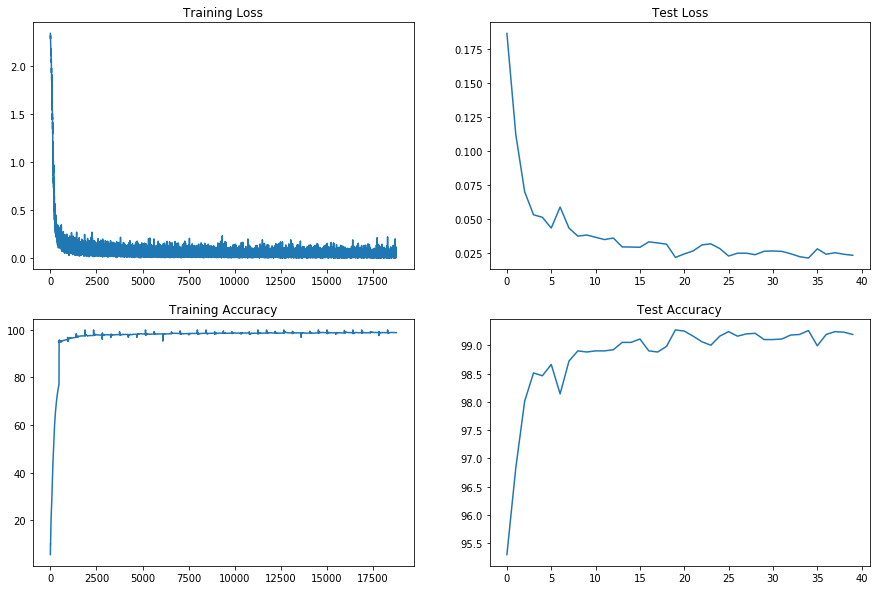

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")